# Machine Learning with Spark ML

### In this notebook, we will explore machine learning using Spark ML. We will exploit Spark ML's high-level APIs built on top of DataFrames to create and tune machine learning pipelines. Spark ML Pipelines enable combining multiple algorithms into a single pipeline or workflow. We will utilize Spark ML's feature transformers to convert, modify and scale the features that will be used to develop the machine learning model. Finally, we will evaluate and cross validate our model to demonstrate the process of determining a best fit model and load the results in the database.

### We are using machine learning to try to predict diagnoses of breast cancer tumors. We will use data on tumors that have already been diagnosed as benign or malignant a training set for the algorithm .¶

## Table of Contents 
1. [Create Version](#version)
2. [Import Libraries](#import)
3. [Read from Cloud Object Storage](#read)
4. [Transform data](#transform)
5. [PixieDust](#pixie)
6. [Feature Engineering](#engineer)
7. [Define Model](#model)
8. [Create pipeline](#pipeline)
9. [Train the Model](#train)
10. [Evaluate accuracy of the model](#evaluate)
11. [Hyperparameter Tuning](#tuning)
12. [Choose and Utilize the best-fit model](#best)

<a id="version"></a>
## Create Version 
Save a version of the notebook by selecting <b>File</b> > <b>Save Version</b> 
<img alt="IBM Bluemix.Get started now" src="https://raw.githubusercontent.com/jpatter/LMCO/master/Lab-1/images/FileOptions.PNG" > or by selecting the <b>Versions</b> icon and selecting <b>Save Version</b>. <img alt="IBM Bluemix.Get started now" src="https://raw.githubusercontent.com/jpatter/LMCO/master/Lab-1/images/versions-button.png" ><br>
You can have up to ten (10) versions of a notebook.   Notebook versions are saved in a FIFO manner.

## Ensure Spark is installed and up to date 

In [1]:
print('The spark version is {}.'.format(spark.version))

The spark version is 2.1.2.


<a id="import"></a>
## Import the required libraries 

In [2]:
#Imports for Spark
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import Bucketizer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier
from pyspark.sql.functions import year
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

# Imports for pixiedust
from pixiedust.display import *

Pixiedust database opened successfully


<a id="read"></a>
## Read from Cloud Object Storage

In [3]:
# Insert SparkSession DataFrame here
# make CERTAIN to rename the default dataframe name to cancer_df
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '54eK5hQft9uVYbrpsxfWs4Tdgw8sbc8weZndKdj8iwhj',
    'service_id': 'iam-ServiceId-e54eecd9-137d-44ca-b6d3-87b14b0ad21a',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_af2c2a9305dd4cc6a1ce91fbe599e4bb_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
cancer_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('cancer_data.csv', 'mlproject-donotdelete-pr-rwqegunlryj5yq'))
cancer_df.take(5)


[Row(id='1', diagnosis='M', radius_mean='17.99', texture_mean='10.38', perimeter_mean='122.8', area_mean='1001', smoothness_mean='0.1184', compactness_mean='0.2776', concavity_mean='0.3001', concave points_mean='0.1471', symmetry_mean='0.2419', fractal_dimension_mean='0.07871', radius_se='1.095', texture_se='0.9053', perimeter_se='8.589', area_se='153.4', smoothness_se='0.006399', compactness_se='0.04904', concavity_se='0.05373', concave points_se='0.01587', symmetry_se='0.03003', fractal_dimension_se='0.006193', radius_worst='25.38', texture_worst='17.33', perimeter_worst='184.6', area_worst='2019', smoothness_worst='0.1622', compactness_worst='0.6656', concavity_worst='0.7119', concave points_worst='0.2654', symmetry_worst='0.4601', fractal_dimension_worst='0.1189'),
 Row(id='2', diagnosis='M', radius_mean='20.57', texture_mean='17.77', perimeter_mean='132.9', area_mean='1326', smoothness_mean='0.08474', compactness_mean='0.07864', concavity_mean='0.0869', concave points_mean='0.0701

<a id="transform"></a>
## Identify labels and features to transform
A label is the output of an ML model. Since we are creating a model to predict whether a tumor is malignant or benign our label will be "diagnosis".  

A feature is an input of the ML model, in this case the columns that we are using to help predict the diagnosis of a tumor. We will need to tranform each feature into a double so that it can be used properly later on to create train and test the model.

Spark uses Resilient Distributed Datasets (RDDs) which are immutable, meaning if we need to transform a column of the dataframe we must create a new RDD each time we perform a transformation. We can do so using withColumn() and because each feature must be cast as a double we need to transform each feature column.

In [4]:
df_cols = ["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]

dfprev = (cancer_df.withColumn("idTemp", cancer_df["id"]
    .cast("Double")).drop("id").withColumnRenamed("idTemp", "id"))

for df_col in df_cols:
    dfnew = (dfprev.withColumn("temp", dfprev[df_col]
             .cast("Double")).drop(df_col).withColumnRenamed("temp",df_col))
    dfprev = dfnew
    
cancer_nums = dfprev

<a id="pixie"></a>
## Using PixieDust 
We can use PixieDust to explore the data. 

By clicking the grid we can see a table of the dataframe.

If we click the drop down menu symbolized with the graph we can choose to put the data into a scatterplot. We can choose **id** as the key, one of the feature columns (**area_mean**, **perimeter_mean**, etc.) as the value and set the number of rows to display to 1000. We are given a scatterplot of our data points and by choosing the bokeh renderer on the right side, as well as set the color to diagnosis we can see the spread of the different diagnoses.

Example: Set the key for the graph to **id**, the value to **area_mean**, and color to diagnosis. The plot provided allows us to infer that most benign tumors have smaller area when compared to malignant tumors. On the far right of the graph we are presented with our unlabeled points and using the trend of the labeled points we can predict which of the unlabeled tumors may be benign and malignant.

In [5]:
display(cancer_nums)

We can also use PixieDust to the composition of the data. 
Below we group the data by diagnosis so that we can get a count of the number of each diagnosis (M-malignant, B-benign, U-unlabeled). 

Using the table feature we can see that the data has 305 benign tumors, 193 malignant tumors, and 71 unlabeled tumors. 

We can also use a pie chart, created using the drop down menu used previously to make the scatterplot above, to see the percentages of each diagnosis.


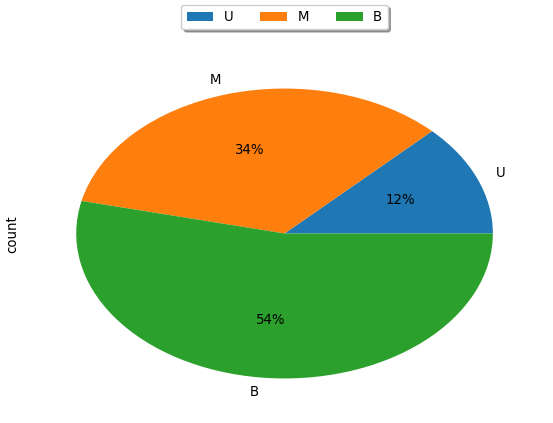

In [7]:
cancer = cancer_nums.groupby("diagnosis").count()
display(cancer)

Because some of our data points are unlabeled we need to filter them out before we train our model.

In [8]:
LabeledData = cancer_nums.filter("diagnosis != 'U'")

<a id="engineer"></a>
## Feature Engineering 
We need to change our label, **diagnosis**, into a form that SparkML can use using StringIndexer. StringIndexer encodes the input column, in our case the diagnosis column, to a column of indices that are representative of the frequency of the input string and are used in training the model.

To turn the label back into a human readable form we can use the converter that we define below using IndexToString. IndexToString maps the column of indices back to the original labels of the column.

In [10]:
labelIndexer = StringIndexer(inputCol="diagnosis", outputCol="label", handleInvalid="error")
labelModel = labelIndexer.fit(LabeledData)
converter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=labelModel.labels)

Now we must put all feature columns into an array using VectorAssembler which combines a list of columns into a single vector column that can be used in training the model.

In [11]:
vecAssembler = VectorAssembler(inputCols=["radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"], outputCol="features")

We use a normalizer to normalize each vector to have a standard form to improve the algorithm.

In [12]:
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

<a id="model"></a>
## State the model to be used 
Next we need to create our logistic regression model that will output its prediction into the **prediction** column.

Logistic Regression is often used for models of binary categorical outcome.

In [13]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

<a id="pipeline"></a>
## Create a pipeline
A pipeline chains together multiple tranformers to specify a specific ML workflow. It is a sequene of pipeline stages that are to be run in a specific order.

In our case, we first want to tranform the label into a usable form for the algorithm, then we create a combined vector, normalize the vector, and finally convert the results back into the original label format.

In [14]:
pipeline = Pipeline(stages=[labelIndexer, vecAssembler, normalizer, lr, converter])

<a id="train"></a>
## Divide data into a training and testing set 
We should split the data randomly with 70% going to the training set and 30% going to the testing set.

In [15]:
train, test = LabeledData.randomSplit([70.0,30.0], seed=1)
train.cache()
test.cache()
print('The number of records in the training data set is {}.'.format(train.count()))
print('The number of rows labeled M is {}.'.format(train.filter(train['diagnosis'] == "M").count()))
print('The number of rows labeled B is {}.'.format(train.filter(train['diagnosis'] == "B").count()))

print()

print('The number of records in the test data set is {}.'.format(test.count()))
print('The number of rows labeled M is {}.'.format(test.filter(train['diagnosis'] == "M").count()))
print('The number of rows labeled B is {}.'.format(test.filter(train['diagnosis'] == "B").count()))

The number of records in the training data set is 357.
The number of rows labeled M is 138.
The number of rows labeled B is 219.

The number of records in the test data set is 141.
The number of rows labeled M is 55.
The number of rows labeled B is 86.


## Fit the model and make predictions 
Next, we need to fit the pipeline to the model and make predictions using the model.

In [16]:
model = pipeline.fit(train)
predictions = model.transform(test)
predictions.count()

141

<a id="evaluate"></a>
## Evaluate the accuracy of the model 
We can use the Reciever Operator Characteristic (ROC) curve for binary classifiers which assess the models diagnositc ability. The ROC is useful for comparing models and choosing the best one for the data. An ROC value close to 1 performs very well, whereas a model with an ROC value close to 0.5 is as good as flipping a coin.

In [17]:
evaluator = BinaryClassificationEvaluator().setLabelCol("label").setMetricName("areaUnderROC")
print('Area under the ROC curve = {}.'.format(evaluator.evaluate(predictions)))

Area under the ROC curve = 0.9890063424947146.


In [ ]:
# UnlabeledData=cancer_nums.filter("diagnosis == 'U'")

In [ ]:
# newPreds = model.transform(UnlabeledData)

In [ ]:
# newPreds.select("id","prediction","predCategory","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst").show()

In [ ]:
# print('The number of records in the unlabeled data set is {}.'.format(newPreds.count()))
# print('The number of rows predicted to be malignant is {}.'.format(newPreds.filter(newPreds['predCategory'] == "M").count()))
# print('The number of rows predicted to be benign is {}.'.format(newPreds.filter(newPreds['predCategory'] == "B").count()))

<a id="tuning"></a>
## Hyperparameter Tuning
We can use model selection tools that:

1. Split the data into training and test datasets
2. For each (training, test) pair, they iterate through the set of ParamMaps
3. For each ParamMap, they fit the pipeline using those parameters, get a fitted Model, and evaluate the Model’s performance
4. Select the Model found using the best-performing set of parameters

To tune our model we will use cross-validation.
A CrossValidator splits the dataset into folds which are used as separate training and testing datasets. We will use 10 folds, so the CrossValidator will generate 10 dataset pairs for training and testing datasets. It will use the average evaluation of the 10 models found using each dataset pair to identify the best ParamMap and re-fit the pipeline using the best ParamMap for the entire dataset.

In [18]:
paramGrid = (ParamGridBuilder().addGrid(lr.elasticNetParam, [0, 0.5, 1.0])
                 .addGrid(normalizer.p, [1.0, 2.0]).build())

In [19]:
cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(10)

In [20]:
cvModel = cv.fit(train)
print('Area under the ROC curve for best fitted model = {}.'.format(evaluator.evaluate(cvModel.transform(test))))

Area under the ROC curve for best fitted model = 0.9947145877378436.


Our cross-validated model was 0.58% better at predicting diagnosis than our original model so we will use the new model for our predictions. 

In [21]:
print('Area under the ROC curve for non-tuned model = {}.'.format(evaluator.evaluate(predictions)))
print('Area under the ROC curve for best fitted model = {}.'.format(evaluator.evaluate(cvModel.transform(test))))
print('Improvement = {0:0.2f}%'.format((evaluator.evaluate(cvModel.transform(test)) - evaluator.evaluate(predictions)) *100 / evaluator.evaluate(predictions)))

Area under the ROC curve for non-tuned model = 0.9890063424947146.
Area under the ROC curve for best fitted model = 0.9947145877378436.
Improvement = 0.58%


<a id="best"></a>
## Finalizing and making predictions using the best model
First we must filter out the data points that are not already labeled so that we can make predictions on diagnoses.

In [27]:
UnlabeledData=cancer_nums.filter("diagnosis == 'U'")

In [23]:
newPreds = cvModel.transform(UnlabeledData)

In [25]:
newPreds.select("id","prediction","predCategory","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst").show()

+-----+----------+------------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|   id|prediction|predCategory|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+-----+----------+--------

In [26]:
print('The number of records in the unlabeled data set is {}.'.format(newPreds.count()))
print('The number of rows labeled malignant is {}.'.format(newPreds.filter(newPreds['predCategory'] == "M").count()))
print('The number of rows labeled benign is {}.'.format(newPreds.filter(newPreds['predCategory'] == "B").count()))

The number of records in the unlabeled data set is 71.
The number of rows labeled malignant is 18.
The number of rows labeled benign is 53.
